In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import pickle

from dessndr import utils, data
import os
import gzip
import shutil
from dessndr.utils import PhotFITS


In [2]:
# Paths to the compressed and decompressed FITS files
compressed_head_file = './DESY5_forcePhoto_real_snana_fits/DESY5_forcePhoto_real_snana_fits_HEAD.FITS.gz'
compressed_phot_file = './DESY5_forcePhoto_real_snana_fits/DESY5_forcePhoto_real_snana_fits_PHOT.FITS.gz'
head_file = './DESY5_forcePhoto_real_snana_fits/DESY5_forcePhoto_real_snana_fits_HEAD.FITS'
phot_file = './DESY5_forcePhoto_real_snana_fits/DESY5_forcePhoto_real_snana_fits_PHOT.FITS'

# Decompress file, skip if decrompressed file already exists

In [ ]:
def decompress_file(input_file, output_file):
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [ ]:
# Decompress the FITS files
decompress_file(compressed_head_file, head_file)
decompress_file(compressed_phot_file, phot_file)

# Initialize PhotFits from dessndr pacakge

In [3]:
# Initialize the PhotFITS class with the version prefix (assuming the prefix is 'DESY5_forcePhoto_real_snana_fits')
version_prefix = './DESY5_forcePhoto_real_snana_fits/DESY5_forcePhoto_real_snana_fits'
phot_fits = PhotFITS(version_prefix)

# Display the head and photometry tables
print("Header DataFrame:")
print(phot_fits.head_df.head())

print("Photometry DataFrame:")
print(phot_fits.phot_df.head())

# Retrieve and display a specific light curve by SNID (Supernova ID)
example_snid = phot_fits.cid_recs[0]  # Use the first SNID for demonstration
light_curve = phot_fits.get_lc(example_snid)
print(f"Light curve for SNID {example_snid}:")
print(light_curve.head())

Header DataFrame:
      SNID                 IAUC  FAKE  MASK_FLUXCOR_SNANA         RA  \
0  1770178  b'DES17E2a        '     0                   0  10.026505   
1  1770181  b'DES17E2b        '     0                   0   8.882446   
2  1770187  b'DES17E1af       '     0                   0   7.423758   
3  1770191  b'DES17E1ag       '     0                   0   6.785357   
4  1770196  b'DES17E1sh       '     0                   0   8.796666   

         DEC  PIXSIZE  NXPIX  NYPIX  SNTYPE  ...  PRIVATE(DES_nobs_photerr)  \
0 -43.649662     0.27   2048   4096     101  ...                        3.0   
1 -44.307575     0.27   2048   4096       1  ...                        6.0   
2 -42.229542     0.27   2048   4096       0  ...                        7.0   
3 -42.523838     0.27   2048   4096     180  ...                       42.0   
4 -43.358242     0.27   2048   4096       0  ...                       10.0   

   PRIVATE(DES_hostgal_gradient_g)  PRIVATE(DES_hostgal_gradient_r)  \
0  

/hpc/group/cosmology/qc59/miniconda3/envs/anomaly3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/hpc/group/cosmology/qc59/miniconda3/envs/anomaly3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Plot Ligth curve to check

In [ ]:
# Plot the light curve
def plot_light_curve(light_curve, snid):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Plot flux versus time (MJD) for each band
    for band in light_curve['BAND'].unique():
        mask = light_curve['BAND'] == band
        axes[0].errorbar(light_curve['MJD'][mask], light_curve['FLUXCAL'][mask], yerr=light_curve['FLUXCALERR'][mask], label=f'Band {band}', fmt='o')

    axes[0].set_xlabel('MJD')
    axes[0].set_ylabel('Flux (FLUXCAL)')
    axes[0].set_title(f'Flux Light Curve for SNID {snid}')
    axes[0].legend()
    axes[0].grid(True)

    # Plot magnitude versus time (MJD) for each band
    for band in light_curve['BAND'].unique():
        mask = light_curve['BAND'] == band
        # Calculate magnitude and its error
        mag = -2.5 * np.log10(light_curve['FLUXCAL'][mask]) + 27.5
        mag_err = 2.5 / np.log(10) * light_curve['FLUXCALERR'][mask] / light_curve['FLUXCAL'][mask]
        axes[1].errorbar(light_curve['MJD'][mask], mag, yerr=mag_err, label=f'Band {band}', fmt='o')

    axes[1].invert_yaxis()  # Magnitude is typically plotted with the y-axis inverted
    axes[1].set_xlabel('MJD')
    axes[1].set_ylabel('Magnitude')
    axes[1].set_title(f'Magnitude Light Curve for SNID {snid}')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the light curve
plot_light_curve(light_curve, example_snid)

# prepare data and preprocess data

In [15]:
def prepare_light_curve_data(phot_fits, num_light_curves='all', random_seed=None):
    """
    Prepare light curve data for anomaly detection.
    
    Parameters:
    phot_fits: PhotFITS instance containing the head and photometry tables.
    num_light_curves: 'all' for full data, or an integer for the number of light curves to include.
    random_seed: Seed for reproducibility if num_light_curves is an integer and random selection is desired.
    
    Returns:
    combined_df: Combined DataFrame with the selected light curves.
    """
    # Retrieve the head and photometry tables
    head_df = phot_fits.head_df
    phot_df = phot_fits.phot_df

    # Create the 'SNID' column in phot_df
    phot_df['SNID'] = np.nan

    # Assign SNID to each row in phot_df based on PTROBS_MIN and PTROBS_MAX
    for i, row in head_df.iterrows():
        snid = row['SNID']
        ptrobs_min = row['PTROBS_MIN']
        ptrobs_max = row['PTROBS_MAX']
        phot_df.loc[ptrobs_min:ptrobs_max, 'SNID'] = snid

    # Drop rows without SNID
    phot_df.dropna(subset=['SNID'], inplace=True)
    phot_df['SNID'] = phot_df['SNID'].astype(int)

    # Select SNIDs based on the user's choice
    if num_light_curves == 'all':
        selected_snids = head_df['SNID'].unique()
    else:
        if random_seed is not None:
            np.random.seed(random_seed)
        selected_snids = np.random.choice(head_df['SNID'].unique(), num_light_curves, replace=False)

    selected_head_df = head_df[head_df['SNID'].isin(selected_snids)]
    selected_phot_df = phot_df[phot_df['SNID'].isin(selected_snids)]

    # Combine the data for the selected SNIDs
    combined_df = pd.merge(selected_phot_df, selected_head_df, on='SNID')

    # Clean the 'BAND' values by stripping any extra spaces
    combined_df['BAND'] = combined_df['BAND'].str.strip()

    # Mapping BAND to mean wavelengths in micrometers
    band_wavelength_mapping = {
        'u': (320 + 400) / (2 * 1000),
        'g': (400 + 552) / (2 * 1000),
        'r': (552 + 691) / (2 * 1000),
        'i': (691 + 818) / (2 * 1000),
        'z': (818 + 922) / (2 * 1000),
        'Y': (950 + 1080) / (2 * 1000)
    }
    
    # Add WAVELENGTH column based on BAND
    combined_df['WAVELENGTH'] = combined_df['BAND'].map(band_wavelength_mapping)

    # Filter out invalid 'BAND' values
    valid_bands = set(band_wavelength_mapping.keys())
    combined_df = combined_df[combined_df['BAND'].isin(valid_bands)]

    return combined_df

def process_light_curves_and_host_gal(combined_df, timesteps=656):
    """
    Process light curves and host galaxy data for anomaly detection.
    
    Parameters:
    combined_df: DataFrame containing combined light curve and head data.
    timesteps: Number of timesteps for padding the light curves.
    
    Returns:
    light_curves: Numpy array of processed light curves.
    host_gals: Numpy array of host galaxy data.
    """
    light_curves = []
    host_gals = []

    for snid in combined_df['SNID'].unique():
        sn_phot = combined_df[combined_df['SNID'] == snid]
        light_curve = sn_phot[['WAVELENGTH','MJD', 'FLUXCAL', 'FLUXCALERR']].values
        
        # Scale FLUXCAL and FLUXCALERR
        light_curve[:, 2] /= 500
        light_curve[:, 3] /= 500
        
        # Scale MJD to time since trigger
        time_since_trigger = light_curve[:, 1] - sn_phot['PEAKMJD'].values[0]
        light_curve[:, 1] = time_since_trigger / 100  # Adjust scaling as needed
        
        light_curves.append(light_curve)
        
        host_gal = sn_phot[['REDSHIFT_FINAL', 'MWEBV']].values[0]
        host_gals.append(host_gal)

    # Pad the light curves if necessary
    def pad_light_curves(light_curves, timesteps=656):
        padded_curves = []
        for lc in light_curves:
            if lc.shape[0] < timesteps:
                padded_lc = np.pad(lc, ((0, timesteps - lc.shape[0]), (0, 0)), mode='constant')
            else:
                padded_lc = lc[:656]
            padded_curves.append(padded_lc)
        return np.array(padded_curves)

    light_curves = pad_light_curves(light_curves, timesteps)

    # Convert to numpy arrays
    host_gals = np.array(host_gals)

    return light_curves, host_gals



In [24]:
# Example usage
combined_df = prepare_light_curve_data(phot_fits, num_light_curves='all', random_seed=42)
print("Combined DataFrame for the selected SNIDs:")
print(combined_df.head())

light_curves, host_gals = process_light_curves_and_host_gal(combined_df)
print("Processed light curves and host galaxy data.")

Combined DataFrame for the selected SNIDs:
          MJD BAND  CCDNUM  IMGNUM         FIELD  PHOTFLAG  PHOTPROB  \
0  56520.2382    r      17  226671  E2                   1      -9.0   
1  56520.2403    i      17  226672  E2                   1      -9.0   
2  56520.2429    z      17  226673  E2                   1      -9.0   
3  56534.1853    g      17  228734  E2                2049      -9.0   
4  56534.1876    r      17  228735  E2                2049      -9.0   

    FLUXCAL  FLUXCALERR  PSF_SIG1  ...  PRIVATE(DES_hostgal_gradient_g)  \
0  -0.24092      5.0410     1.700  ...                            -8.58   
1  11.78500      5.9726     1.670  ...                            -8.58   
2  -0.77596      9.5390     1.673  ...                            -8.58   
3  -6.68510      3.0713     2.053  ...                            -8.58   
4  -1.83770      5.2810     2.040  ...                            -8.58   

   PRIVATE(DES_hostgal_gradient_r)  PRIVATE(DES_hostgal_gradient_i)  \
0 

In [26]:
def save(save_path , obj):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)

os.makedirs("processed", exist_ok=True)        

save("processed/x_data.pkl", light_curves)
save("processed/host_galaxy_info.pkl", host_gals)

In [27]:
# Load data

def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)
x_data = load("processed/x_data.pkl")
host_galaxy_info = load("processed/host_galaxy_info.pkl")

# Load pretrained model and calculate anomaly scores

In [17]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from sklearn.ensemble import IsolationForest

# Paths to the pretrained models
pretrained_model_path = '/hpc/group/cosmology/qc59/miniconda3/envs/anomaly3/lib/python3.9/site-packages/astromcad/pretrained.keras'
isolation_forest_path = '/hpc/group/cosmology/qc59/miniconda3/envs/anomaly3/lib/python3.9/site-packages/astromcad/iforests.pickle'

# Load the pretrained Keras model
pretrained_model = load_model(pretrained_model_path)

# Assuming the model's latent space output layer is named 'latent'
latent_layer_name = 'latent'
latent_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer(latent_layer_name).output)

# Verify the output shape of the latent layer
latent_output_shape = latent_model.output_shape[-1]
print(f"Latent layer output shape: {latent_output_shape}")

if latent_output_shape != 100:
    raise ValueError(f"The latent layer output shape is {latent_output_shape}, but the Isolation Forest expects 100 features.")

# Load the pretrained Isolation Forest models (mcif object)
with open(isolation_forest_path, 'rb') as f:
    isolation_forest_mcif = pickle.load(f)

# Prepare your data
# light_curves should be of shape (N_SAMPLES, 656, 4)
# host_gals should be of shape (N_SAMPLES, 2)

# Encode the light curve data using the latent model
encoded_data = latent_model.predict([light_curves, host_gals])

# Calculate anomaly scores using the mcif object
anomaly_scores_list = isolation_forest_mcif.score(encoded_data)
anomaly_scores = -np.array(anomaly_scores_list)
# Print the anomaly scores
print("Anomaly Scores:")
print(anomaly_scores)

Latent layer output shape: 100
2/2 [==============================] - 15s 1s/step
Anomaly Scores:
[-0.12961969  0.02051678  0.03611998 -0.0178609  -0.12961969 -0.12961969
 -0.12961969  0.03746641 -0.12961969 -0.01992121 -0.12961969 -0.12961969
 -0.12961969 -0.12045387 -0.12003422 -0.12961969 -0.12961969 -0.12961969
 -0.12399819 -0.12961969 -0.12961969 -0.12961969 -0.12594461 -0.12961969
 -0.12961969 -0.12961969 -0.05145386 -0.12961969 -0.12961969 -0.12003422
 -0.12594461 -0.12961969 -0.12961969 -0.12103925  0.04723281 -0.12594461
  0.0325231  -0.12961969 -0.12961969 -0.12003422 -0.12961969 -0.12961969
  0.03621099  0.02496943 -0.12961969 -0.0333872  -0.12961969  0.0390275
 -0.12961969 -0.12594461]


# visualizaions:

In [18]:
# Visualize Anomaly Scores
def plot_anomaly_scores(anomaly_scores, snid_list):
    plt.figure(figsize=(10, 6))
    plt.plot(anomaly_scores, 'o-', markersize=5, label='Anomaly Score')
    plt.xlabel('SNID Index')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Scores for Light Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to calculate and visualize additional metrics
def calculate_and_plot_metrics(anomaly_scores, snid_list):
    # Calculate basic statistics
    mean_anomaly_score = np.mean(anomaly_scores)
    median_anomaly_score = np.median(anomaly_scores)
    std_anomaly_score = np.std(anomaly_scores)

    # Print basic statistics
    print(f"Mean Anomaly Score: {mean_anomaly_score}")
    print(f"Median Anomaly Score: {median_anomaly_score}")
    print(f"Standard Deviation of Anomaly Scores: {std_anomaly_score}")

    # Plot histogram of anomaly scores
    plt.figure(figsize=(10, 6))
    plt.hist(anomaly_scores, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Anomaly Scores')
    plt.grid(True)
    plt.show()

    # Scatter plot of anomaly scores with SNIDs
    plt.figure(figsize=(10, 6))
    plt.scatter(snid_list, anomaly_scores, c='b', alpha=0.6, edgecolor='k')
    plt.xlabel('SNID')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Scores by SNID')
    plt.grid(True)
    plt.show()

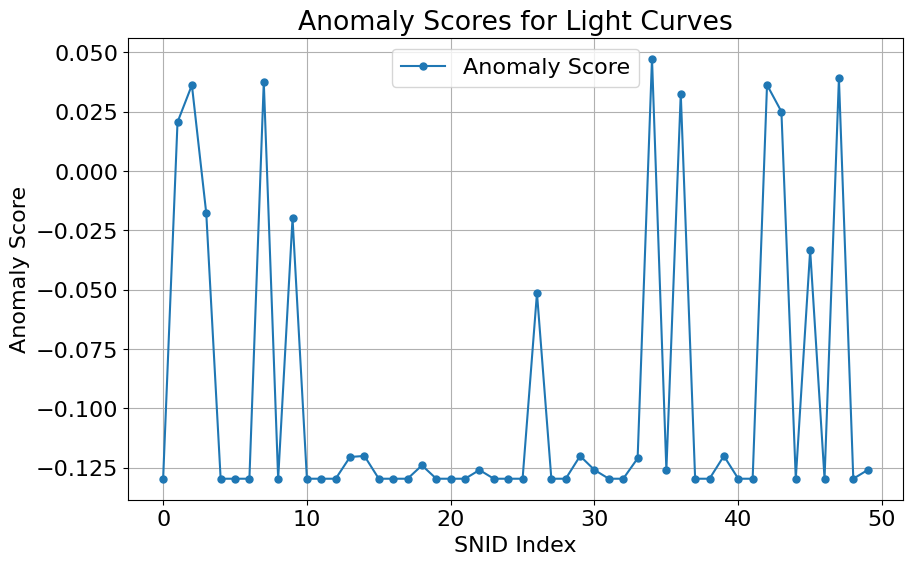

Mean Anomaly Score: -0.09414559566451632
Median Anomaly Score: -0.12961968503018617
Standard Deviation of Anomaly Scores: 0.06210115079060551


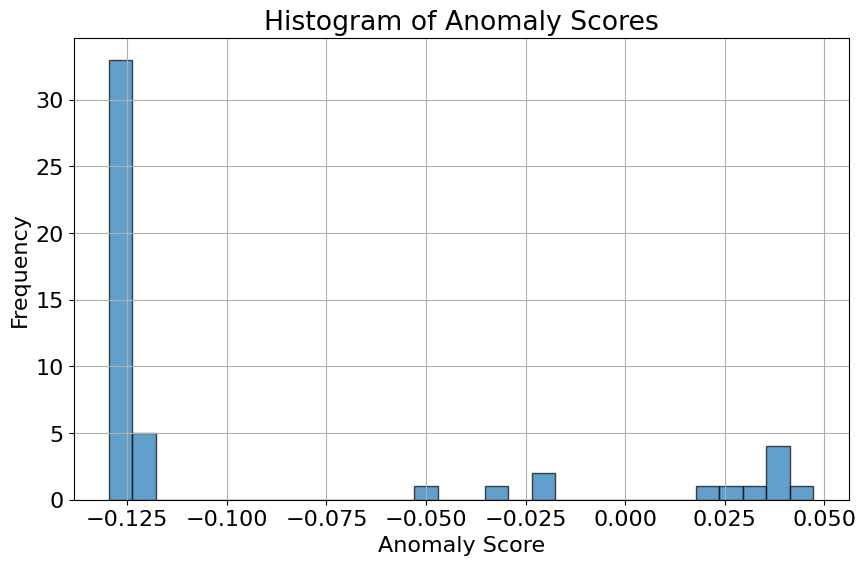

ValueError: x and y must be the same size

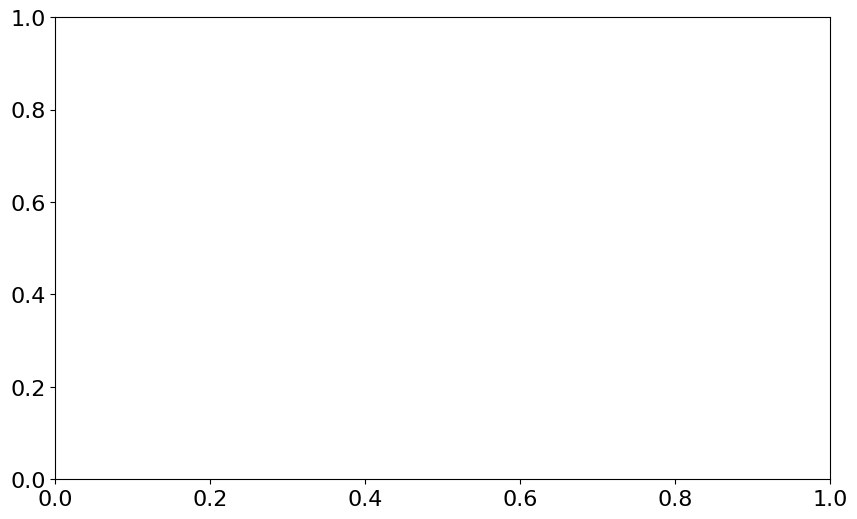

In [25]:
# Visualize the anomaly scores
snid_list = combined_df['SNID'].unique()
plot_anomaly_scores(anomaly_scores, snid_list)

# Calculate and visualize additional metrics
calculate_and_plot_metrics(anomaly_scores, snid_list)

In [20]:
from sklearn.preprocessing import LabelEncoder

def median_anomaly_score(anomaly_scores, combined_df, title="", savepath=None):
    # Encode the supernova types as numerical labels
    label_encoder = LabelEncoder()
    combined_df['SNTYPE_LABEL'] = label_encoder.fit_transform(combined_df['SNTYPE'])

    # Get the list of unique supernova types
    sn_types = label_encoder.classes_

    # Initialize dictionary to store anomaly scores for each type
    score_dist = {sn_type: [] for sn_type in sn_types}

    # Group anomaly scores by supernova type
    for sn_type in sn_types:
        snid_list = combined_df[combined_df['SNTYPE'] == sn_type]['SNID'].unique()
        for snid in snid_list:
            idx = np.where(combined_df['SNID'] == snid)[0][0]
            score_dist[sn_type].append(anomaly_scores[idx])

    # Calculate median anomaly scores for each type
    for sn_type in score_dist.keys():
        score_dist[sn_type] = np.median(score_dist[sn_type])

    # Plot the median anomaly scores
    fig, ax = plt.subplots(figsize=(13, 13))
    medians = list(score_dist.values())

    cmap = matplotlib.cm.Blues(np.linspace(0, 1, 100))
    cmap = matplotlib.colors.ListedColormap(cmap[25:75, :-1])

    im = ax.imshow([medians], cmap=cmap)

    ax.set_yticks([])
    ax.set_xticks(range(len(medians)), list(score_dist.keys()), fontsize=15, rotation=45)
    for x in range(len(medians)):
        ax.annotate(str(round(medians[x], 2)), xy=(x, 0),
                    horizontalalignment='center',
                    verticalalignment='center', fontsize=15, fontweight="bold")
    ax.set_title(title, fontsize=20)
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()

In [21]:
median_anomaly_score(anomaly_scores, combined_df, title="Median Anomaly Scores by Supernova Type")

IndexError: index 463 is out of bounds for axis 0 with size 50